<img src="https://raw.githubusercontent.com/OGGM/oggm/master/docs/_static/logo.png" width="40%"  align="left">

# Getting started with OGGM: Ötztal case study

The OGGM workflow is best explained with an example. We are going to use the case we use for testing the oggm codebase. The test files are located in a dedicated online repository, [oggm-sample-data](https://github.com/OGGM/oggm-sample-data).

## Input data

In the `test-workflow` directory you can have a look at the various files we will need. oggm also needs them for testing, so they are automatically available to everybody with a simple mechanism:

In [1]:
import oggm
from oggm import cfg
from oggm.utils import get_demo_file
cfg.initialize()
srtm_f = get_demo_file('srtm_oetztal.tif')
rgi_f = get_demo_file('rgi_oetztal.shp')
print(srtm_f)

2017-06-05 18:25:37: oggm.cfg: Parameter file: /home/mowglie/Documents/git/oggm-fork/oggm/params.cfg


/home/mowglie/.oggm/oggm-sample-data-master/test-workflow/srtm_oetztal.tif


The very first time that you make a call to `get_demo_file()`, oggm will create a hidden `.oggm` directory in your home folder$^*$ and download the demo files in it.

<sub>*: this path might vary depending on your platform, see python's [expanduser](https://docs.python.org/3.5/library/os.path.html#os.path.expanduser)</sub>

### DEM and glacier outlines

The data directory contains a subset of the RGI V4 for the Ötztal:

In [2]:
import salem  # https://github.com/fmaussion/salem
rgi_shp = salem.read_shapefile(rgi_f).set_index('RGIId')

We'll have a look at it, but first we will need to make some imports and set some defaults:

In [3]:
# Plot defaults
%matplotlib inline
import matplotlib.pyplot as plt
# Packages
import os
import numpy as np
import xarray as xr
import shapely.geometry as shpg
plt.rcParams['figure.figsize'] = (8, 8)  # Default plot size

Plot the glaciers of the Ötztal case study:

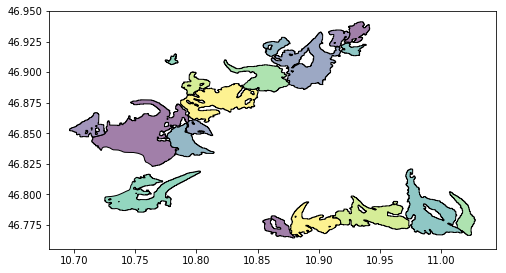

In [4]:
rgi_shp.plot();

### Calibration / validation data

These 19 glaciers were selected because they have either mass-balance data (WGMS) or total volume information (GlaThiDa). These data are required for calibration/validation and are available automatically in OGGM.

### Climate data

For this test case we use HISTALP data (which goes back further in time than CRU), stored in the NetCDF format. The resolution of HISTALP (5 minutes of arc) is relatively high, but some kind of downscaling will be necessary to compute the mass-balance at the glacier scale.

We can plot a timeseries of the data, for example for the grid point (3, 3):

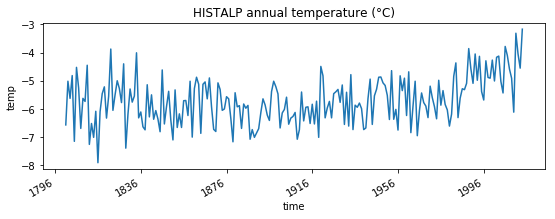

In [5]:
fig = plt.figure(figsize=(9, 3))
ds = xr.open_dataset(get_demo_file('HISTALP_oetztal.nc'))
ds.temp[:, 3, 3].resample('AS', dim='time').plot()
plt.title('HISTALP annual temperature (°C)');

## Setting up an OGGM run

OGGM parameters are gathered in a configuration file. The [default file](https://github.com/OGGM/oggm/blob/master/oggm/params.cfg) is shipped with the code. It is used to initialize the configuration module:

In [6]:
from oggm import cfg
from oggm import workflow
cfg.initialize()  # read the default parameter file

2017-06-05 18:25:38: oggm.cfg: Parameter file: /home/mowglie/Documents/git/oggm-fork/oggm/params.cfg


For example, the `cfg` module has a global variable `PATHS` (a dictionary) storing the file paths to the data and working directories:

In [7]:
cfg.PATHS

PathOrderedDict([('dl_cache_dir',
                  '/home/mowglie/disk/OGGM_INPUT/download_cache'),
                 ('tmp_dir', '/home/mowglie/disk/OGGM_INPUT/tmp'),
                 ('cru_dir', '/home/mowglie/disk/OGGM_INPUT/cru'),
                 ('rgi_dir', '/home/mowglie/disk/OGGM_INPUT/rgi'),
                 ('test_dir', '/home/mowglie/tmp/OGGM_tests'),
                 ('working_dir', '/home/mowglie/OGGM_WORKING_DIRECTORY'),
                 ('dem_file', ''),
                 ('climate_file', ''),
                 ('wgms_rgi_links', ''),
                 ('glathida_rgi_links', ''),
                 ('leclercq_rgi_links', '')])

The path to the input data files are missing. Let's set them so that the oggm modules know where to look for them (the default would be to download them automatically, which we would like to avoid for this example):

In [8]:
cfg.PATHS['dem_file'] = get_demo_file('srtm_oetztal.tif')
cfg.PATHS['climate_file'] = get_demo_file('HISTALP_oetztal.nc')

We will set the "border" option to a larger value, since we will do some dynamical simulations ("border" decides on the number of DEM grid points we'd like to add to each side of the glacier for the local map: the larger the glacier will grow, the larger border should be):

In [9]:
cfg.PARAMS['border'] = 80

We keep the other parameters to their default values, for example the precipitation scaling factor:

In [10]:
cfg.PARAMS['prcp_scaling_factor']

2.5

## Glacier working directories

An OGGM "run" is made of several successive tasks to be applied on each glacier. Because these tasks can be computationally expensive they are split in smaller tasks, each of them storing their results in a [glacier directory](http://oggm.readthedocs.org/en/latest/glacierdir-gen.html).

The very first task of an OGGM run is always `init_glacier_regions`:

In [11]:
# Read in the RGI file
import geopandas as gpd
rgi_file = get_demo_file('rgi_oetztal.shp')
rgidf = gpd.GeoDataFrame.from_file(rgi_file)
# Initialise directories
# reset=True will ask for confirmation if the directories are already present: 
# this is very useful if you don't want to loose hours of computations because of a command gone wrong
gdirs = oggm.workflow.init_glacier_regions(rgidf, reset=True)

Delete all glacier directories? [Y/n] Y


2017-06-05 18:25:42: oggm.workflow: Multiprocessing: using all available processors (N=4)
2017-06-05 18:25:42: oggm.core.preprocessing.gis: RGI50-11.00663: define_glacier_region
2017-06-05 18:25:42: oggm.core.preprocessing.gis: RGI50-11.00648: define_glacier_region
2017-06-05 18:25:42: oggm.core.preprocessing.gis: RGI50-11.00666: define_glacier_region
2017-06-05 18:25:42: oggm.core.preprocessing.gis: RGI50-11.00670: define_glacier_region
2017-06-05 18:25:42: oggm.core.preprocessing.gis: RGI50-11.00674: define_glacier_region
2017-06-05 18:25:42: oggm.core.preprocessing.gis: RGI50-11.00684: define_glacier_region
2017-06-05 18:25:42: oggm.core.preprocessing.gis: RGI50-11.00687: define_glacier_region
2017-06-05 18:25:42: oggm.core.preprocessing.gis: RGI50-11.00698: define_glacier_region
2017-06-05 18:25:42: oggm.core.preprocessing.gis: RGI50-11.00719: define_glacier_region
2017-06-05 18:25:42: oggm.core.preprocessing.gis: RGI50-11.00746: define_glacier_region
2017-06-05 18:25:42: oggm.core

2017-06-05 18:26:02: oggm.core.preprocessing.geometry: RGI50-11.00698: catchment_area, divide 1
2017-06-05 18:26:02: oggm.core.preprocessing.geometry: RGI50-11.00719: catchment_area, divide 1
2017-06-05 18:26:04: oggm.core.preprocessing.geometry: RGI50-11.00746: catchment_area, divide 1
2017-06-05 18:26:06: oggm.core.preprocessing.geometry: RGI50-11.00719: catchment_area, divide 2
2017-06-05 18:26:06: oggm.core.preprocessing.geometry: RGI50-11.00770: catchment_area, divide 1
2017-06-05 18:26:07: oggm.core.preprocessing.geometry: RGI50-11.00779: catchment_area, divide 1
2017-06-05 18:26:07: oggm.core.preprocessing.geometry: RGI50-11.00787: catchment_area, divide 1
2017-06-05 18:26:10: oggm.core.preprocessing.geometry: RGI50-11.00887: catchment_area, divide 1
2017-06-05 18:26:13: oggm.core.preprocessing.geometry: RGI50-11.00897: catchment_area, divide 1
2017-06-05 18:26:13: oggm.core.preprocessing.geometry: RGI50-11.00929: catchment_area, divide 1
2017-06-05 18:26:13: oggm.core.preproces

2017-06-05 18:26:35: oggm.core.preprocessing.geometry: RGI50-11.00663: catchment_width_correction
2017-06-05 18:26:35: oggm.core.preprocessing.geometry: RGI50-11.00670: catchment_width_correction
2017-06-05 18:26:35: oggm.core.preprocessing.geometry: RGI50-11.00666: catchment_width_correction
2017-06-05 18:26:35: oggm.core.preprocessing.geometry: RGI50-11.00648: width correction, divide 1
2017-06-05 18:26:35: oggm.core.preprocessing.geometry: RGI50-11.00663: width correction, divide 1
2017-06-05 18:26:35: oggm.core.preprocessing.geometry: RGI50-11.00670: width correction, divide 1
2017-06-05 18:26:35: oggm.core.preprocessing.geometry: RGI50-11.00663: catchment_width_correction
2017-06-05 18:26:35: oggm.core.preprocessing.geometry: RGI50-11.00648: catchment_width_correction
2017-06-05 18:26:35: oggm.core.preprocessing.geometry: RGI50-11.00670: catchment_width_correction
2017-06-05 18:26:35: oggm.core.preprocessing.geometry: RGI50-11.00666: width correction, divide 1
2017-06-05 18:26:35:

2017-06-05 18:27:10: oggm.core.preprocessing.climate: RGI50-11.00663: process_custom_climate_data
2017-06-05 18:27:10: oggm.core.preprocessing.climate: RGI50-11.00648: process_custom_climate_data
2017-06-05 18:27:10: oggm.core.preprocessing.climate: RGI50-11.00666: process_custom_climate_data
2017-06-05 18:27:10: oggm.core.preprocessing.climate: RGI50-11.00670: process_custom_climate_data
2017-06-05 18:27:11: oggm.core.preprocessing.climate: RGI50-11.00674: process_custom_climate_data
2017-06-05 18:27:11: oggm.core.preprocessing.climate: RGI50-11.00684: process_custom_climate_data
2017-06-05 18:27:11: oggm.core.preprocessing.climate: RGI50-11.00687: process_custom_climate_data
2017-06-05 18:27:11: oggm.core.preprocessing.climate: RGI50-11.00698: process_custom_climate_data
2017-06-05 18:27:12: oggm.core.preprocessing.climate: RGI50-11.00719: process_custom_climate_data
2017-06-05 18:27:12: oggm.core.preprocessing.climate: RGI50-11.00746: process_custom_climate_data
2017-06-05 18:27:12:

2017-06-05 18:35:05: oggm.core.models.flowline: RGI50-11.00687: init_present_time_glacier
2017-06-05 18:35:05: oggm.core.models.flowline: RGI50-11.00684: init_present_time_glacier
2017-06-05 18:35:05: oggm.core.models.flowline: RGI50-11.00698: init_present_time_glacier
2017-06-05 18:35:05: oggm.core.models.flowline: RGI50-11.00719: init_present_time_glacier
2017-06-05 18:35:05: oggm.core.models.flowline: RGI50-11.00746: init_present_time_glacier
2017-06-05 18:35:05: oggm.core.models.flowline: RGI50-11.00779: init_present_time_glacier
2017-06-05 18:35:05: oggm.core.models.flowline: RGI50-11.00770: init_present_time_glacier
2017-06-05 18:35:05: oggm.core.models.flowline: RGI50-11.00887: init_present_time_glacier
2017-06-05 18:35:05: oggm.core.models.flowline: RGI50-11.00787: init_present_time_glacier
2017-06-05 18:35:06: oggm.core.models.flowline: RGI50-11.00897: init_present_time_glacier
2017-06-05 18:35:06: oggm.core.models.flowline: RGI50-11.00929: init_present_time_glacier
2017-06-05

Note that if I run `init_glacier_regions` a second time without `reset=True`, nothing special happens. The directories will not be overwritten, just "re-opened":

In [12]:
gdirs = workflow.init_glacier_regions(rgidf)

Now what is the variable `gdirs`? It is a list of 19 [GlacierDirectory](http://oggm.readthedocs.org/en/latest/generated/oggm.GlacierDirectory.html#oggm.GlacierDirectory) objects. They are here to help us to handle data input/output and to store several glacier properties. Here are some examples: 

In [13]:
gdir = gdirs[13]
gdir

<oggm.GlacierDirectory>
  RGI id: RGI50-11.00887
  Region: 11: Central Europe
  Subregion: 11-01: Alps
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 8.938 mk2
  Lon, Lat: (10.9827, 46.7845)
  Grid (nx, ny): (224, 268)
  Grid (dx, dy): (55.0, -55.0)

`gdir` provides a `get_filepath` function which gives access to the data files present in the directory:

In [14]:
gdir.get_filepath('dem')

'/home/mowglie/OGGM_WORKING_DIRECTORY/per_glacier/RGI50-11/RGI50-11.00/RGI50-11.00887/dem.tif'

`dem.tif` is a local digital elevation map with a spatial resolution chosen by OGGM as a function of the glacier size. These [GlacierDirectory](http://oggm.readthedocs.org/en/latest/generated/oggm.GlacierDirectory.html#oggm.GlacierDirectory) objects are going to be the input of almost every OGGM task.

This data model has been chosen so that even complex functions requires serval input data can be called with one single argument: 

2017-06-05 18:25:43: oggm.graphics: RGI50-11.00887: plot_googlemap


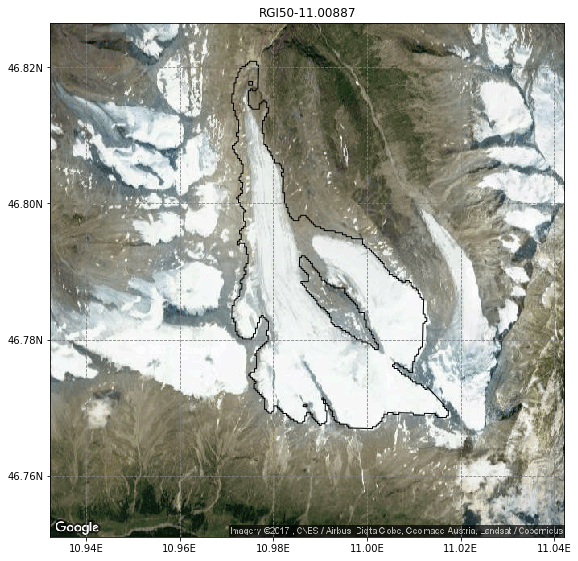

In [15]:
from oggm import graphics
graphics.plot_googlemap(gdir)

## OGGM tasks

The workflow of OGGM is oriented around the concept of "[tasks](http://oggm.readthedocs.org/en/latest/api.html#entity-tasks)". There are two different types:

**Entity Task**:
  Standalone operations to be realized on one single glacier entity,
  independently from the others. The majority of OGGM
  tasks are entity tasks. They are parallelisable.

**Global Task**:
  tasks which require to work on several glacier entities
  at the same time. Model parameter calibration or interpolation of degree day factors belong to
  this type of task. They are not parallelisable.
  
OGGM implements a simple mechanism to run a specific task on a list of `GlacierDir` objects (here, the function `glacier_masks()` from the module `oggm.prepro.gis`):

In [16]:
from oggm import tasks

In [17]:
# run the glacier_masks task on all gdirs
workflow.execute_entity_task(tasks.glacier_masks, gdirs)

We just computed gridded boolean [masks](http://oggm.readthedocs.org/en/latest/generated/oggm.tasks.glacier_masks.html#oggm.tasks.glacier_masks) out of the RGI outlines.

It is also possible to apply several tasks sequentially:

In [18]:
list_talks = [
         tasks.compute_centerlines,
         tasks.compute_downstream_lines,
         tasks.catchment_area,
         tasks.initialize_flowlines,
         tasks.catchment_width_geom,
         tasks.catchment_width_correction,
         tasks.compute_downstream_bedshape
         ]
for task in list_talks:
    workflow.execute_entity_task(task, gdirs)

The function `execute_task` can run a task on different glaciers at the same time, if the `use_multiprocessing` option is set to `True` in the configuration file. 

With all these tasks we just computed the glacier flowlines and their width:

2017-06-05 18:27:09: oggm.graphics: RGI50-11.00887: plot_catchment_width


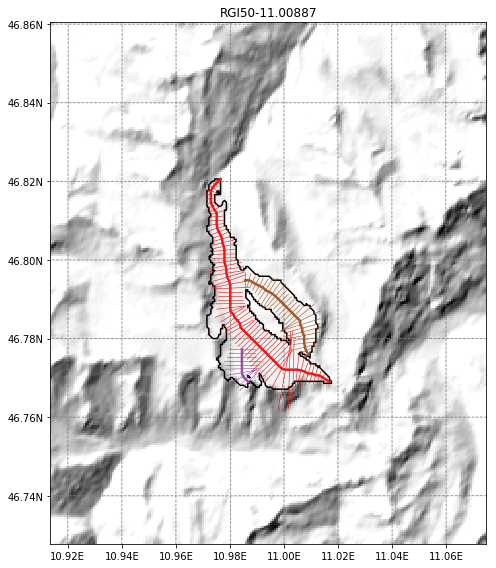

In [19]:
graphics.plot_catchment_width(gdir, corrected=True)

### Global tasks, climate tasks

We will go into more detail about tasks in the documentation. For now, we will use the helper function:

In [20]:
workflow.climate_tasks(gdirs)

2017-06-05 18:27:13: oggm.core.preprocessing.climate: Compute the reference t* and mu* for WGMS glaciers
2017-06-05 18:27:13: oggm.core.preprocessing.climate: RGI50-11.00719: mu_candidates, divide 1
2017-06-05 18:27:13: oggm.core.preprocessing.climate: RGI50-11.00719: mu_candidates, divide 2
2017-06-05 18:27:13: oggm.core.preprocessing.climate: RGI50-11.00719: mu_candidates, divide 0
2017-06-05 18:27:13: oggm.core.preprocessing.climate: RGI50-11.00787: mu_candidates, divide 1
2017-06-05 18:27:13: oggm.core.preprocessing.climate: RGI50-11.00787: mu_candidates, divide 0
2017-06-05 18:27:13: oggm.core.preprocessing.climate: RGI50-11.00897: mu_candidates, divide 1
2017-06-05 18:27:13: oggm.core.preprocessing.climate: RGI50-11.00897: mu_candidates, divide 2
2017-06-05 18:27:14: oggm.core.preprocessing.climate: RGI50-11.00897: mu_candidates, divide 3
2017-06-05 18:27:14: oggm.core.preprocessing.climate: RGI50-11.00897: mu_candidates, divide 0
2017-06-05 18:27:14: oggm.core.preprocessing.clim

We just read the climate data, "downscaled" it to each glacier, computed possible $\mu^*$ for the reference glaciers, picked the best one, interpolated the corresponding $t^*$ to glaciers without mass-balance observations, computed the mass-balance sensitivity $\mu$ for all glaciers and finally computed the mass-balance at equilibrium (the "apparent mb" in Farinotti et al., 2009).

Finally, we will prepare the data for the inversion, which is an easy:

In [21]:
workflow.execute_entity_task(tasks.prepare_for_inversion, gdirs)

## Inversion

This is where things become a bit more complicated. The inversion is already fully automated in OGGM, but for this tutorial we will try to explain in more detail what is happening.

Let's start with the funcion `mass_conservation_inversion`:

In [22]:
from oggm.core.preprocessing.inversion import mass_conservation_inversion

This function will compute the ice thickness along the flowline. It has one free parameter (or too, if you also want to consider the basal sliding term in the inversion): Glen's deformation parameter A. Let's compute the bed inversion for Hintereisferner and the default A: 

In [23]:
# Select HEF out of all glaciers
gdir_hef = [gd for gd in gdirs if (gd.rgi_id == 'RGI50-11.00897')][0]

In [24]:
glen_a = cfg.A
vol_m3, area_m3 = mass_conservation_inversion(gdir_hef, glen_a=glen_a)
print('With A={}, the mean thickness of HEF is {:.1f} m'.format(glen_a, vol_m3/area_m3))

With A=2.4e-24, the mean thickness of HEF is 96.7 m


2017-06-05 18:27:23: oggm.graphics: RGI50-11.00897: plot_inversion


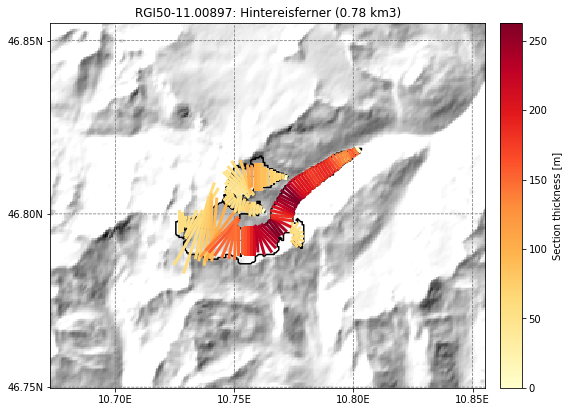

In [25]:
graphics.plot_inversion(gdir_hef)

We know from the literature (Fisher et al, 2013) that the HEF should have an average thickness of 67$\pm$7 m. How sensitive is the inversion to changes in the A parameter?

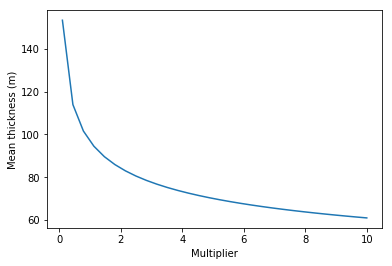

In [26]:
factor = np.linspace(0.1, 10, 30)
thick = factor*0
for i, f in enumerate(factor):
    vol_m3, area_m3 = mass_conservation_inversion(gdir_hef, glen_a=glen_a*f)
    thick[i] = vol_m3/area_m3
plt.figure(figsize=(6, 4))
plt.plot(factor, thick);
plt.ylabel('Mean thickness (m)');
plt.xlabel('Multiplier');

The A parameter controls the deformation of the ice, and therefore the thickness. It is always possible to find a "perfect" A for each glacier with measurements, for example by using an optimisation function. The current way to deal with this in OGGM is to use all glaciers with a volume estimate from the GLaThiDa database, and define A so that the **volume RMSD** is minimized. The reason for choosing the volume (which is strongly affected by the area) over the thickness is that with this method, larger glaciers will have more influence on the final results.

In [27]:
optim_resuls = tasks.optimize_inversion_params(gdirs)

2017-06-05 18:27:24: oggm.core.preprocessing.inversion: Compute the inversion parameter.
2017-06-05 18:27:25: oggm.core.preprocessing.inversion: Optimized glen_a and fs with a factor 5.81 and 0.00 for a thick RMSD of 9.3 m and a volume RMSD of 0.060 km3


The `optimize_inversion_params` task also writes some statistics in the working directory:

In [28]:
import pandas as pd
fpath = os.path.join(cfg.PATHS['working_dir'], 'inversion_optim_results.csv')
df = pd.read_csv(fpath, index_col=0)
df['ref_thick'] = df['ref_volume_km3'] / df['ref_area_km2'] * 1e3
df['oggm_thick'] = df['oggm_volume_km3'] / df['ref_area_km2'] * 1e3
df['vas_thick'] = df['vas_volume_km3'] / df['ref_area_km2'] * 1e3

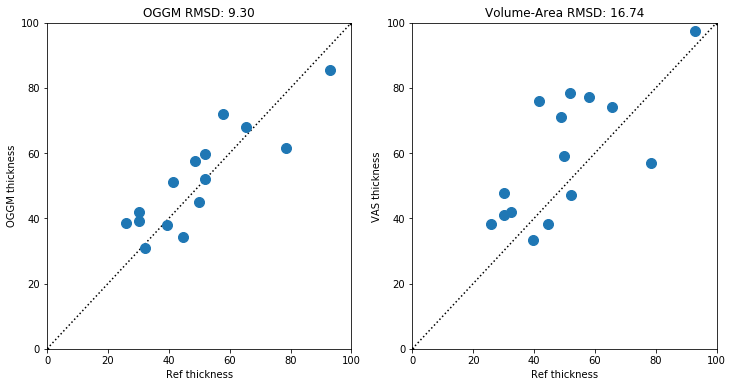

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(df['ref_thick'], df['oggm_thick'], s=100)
ax1.set_title('OGGM RMSD: {:.2f}'.format(oggm.utils.rmsd(df['ref_thick'], df['oggm_thick'])))
ax1.set_xlabel('Ref thickness')
ax1.set_ylabel('OGGM thickness')
ax1.plot([0, 100], [0, 100], '.:k', zorder=0);
ax1.set_xlim([0, 100]), ax1.set_ylim([0, 100]);
ax2.scatter(df['ref_thick'], df['vas_thick'], s=100)
ax2.set_title('Volume-Area RMSD: {:.2f}'.format(oggm.utils.rmsd(df['ref_thick'], df['vas_thick'])))
ax2.set_xlabel('Ref thickness')
ax2.set_ylabel('VAS thickness')
ax2.plot([0, 100], [0, 100], '.:k', zorder=0);
ax2.set_xlim([0, 100]), ax2.set_ylim([0, 100]);

### Finalize the inversion 

In [30]:
# Use the optimal parameters for inveting all glaciers and apply a simple correction filter
workflow.execute_entity_task(tasks.volume_inversion, gdirs)
workflow.execute_entity_task(tasks.filter_inversion_output, gdirs)

## Flowline model

All the previous steps are necessary to run the flowline model: the computation of the flowline(s) and their width, the interpolation of the climate data, the mass-balance sensitivity $\mu$, an estimate of the glacier bed...

All this data are stored in the glacier directories. For example for HEF the data should be approx 2.2 Mb. You can explore the various files available in the directory printed below:

In [31]:
print(gdir_hef.dir)

/home/mowglie/OGGM_WORKING_DIRECTORY/per_glacier/RGI50-11/RGI50-11.00/RGI50-11.00897


The files are partly documented [here](http://oggm.readthedocs.org/en/latest/glacierdir-gen.html#cfg-basenames).

The first task to apply before using the model is the ``init_present_time_glacier`` function:

In [32]:
tasks.init_present_time_glacier(gdir_hef)

2017-06-05 18:27:25: oggm.core.models.flowline: RGI50-11.00897: init_present_time_glacier


This task is required to merge the various glacier divides back together and to allow the glacier to grow by adding the downstream flowlines. This function also decides on the [shape](http://oggm.readthedocs.org/en/latest/flowline.html#glacier-bed-shapes) of the glacier bed along the flowlines and downstream (currently an "average" parabolic shape is chosen). Let's initialize our model with this geometry:

2017-06-05 18:27:25: oggm.graphics: RGI50-11.00897: plot_modeloutput_map


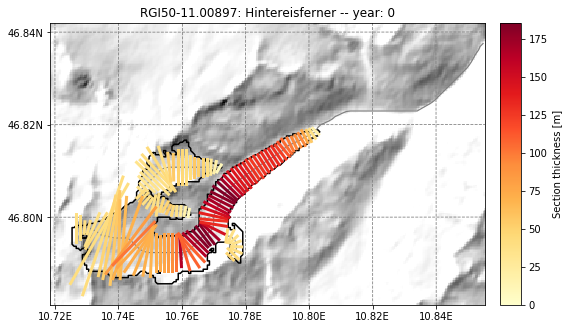

In [33]:
from oggm.core.models.flowline import FluxBasedModel
# the flowlines alone
fls = gdir_hef.read_pickle('model_flowlines')
model = FluxBasedModel(fls)
graphics.plot_modeloutput_map(gdir_hef, model=model);

A cross-section along the glacier can be visualized with the following function:

2017-06-05 18:27:27: oggm.graphics: RGI50-11.00887: plot_modeloutput_section


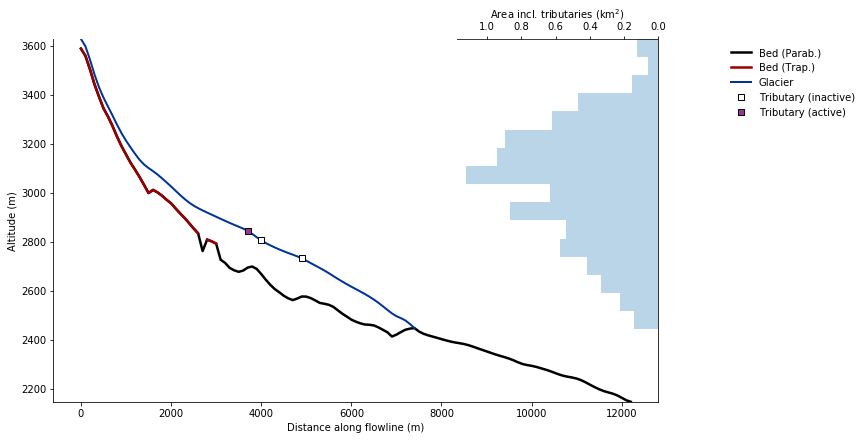

In [34]:
graphics.plot_modeloutput_section(gdir, model=model);

### Mass balance

To run the model, one has to define a mass-balance function. They are implemented in the [massbalance](http://oggm.readthedocs.io/en/latest/api.html#mass-balance) module:

In [35]:
from oggm.core.models.massbalance import ConstantMassBalanceModel
from oggm.core.models.massbalance import PastMassBalanceModel

For example, let's have a look at the mass-balance profile of HEF for the period 1970-2000, for the period $t^*$, and for the year 2003:

In [36]:
today_model = ConstantMassBalanceModel(gdir_hef, y0=1985)
tstar_model = ConstantMassBalanceModel(gdir_hef)
hist_model = PastMassBalanceModel(gdir_hef)

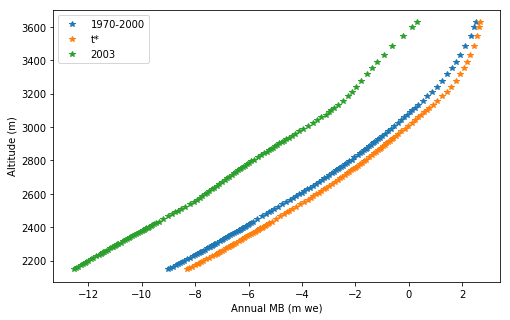

In [37]:
# Altitude of the main flowline:
z = model.fls[-1].surface_h
# Get the mass balance and convert to m per year
mb_today = today_model.get_annual_mb(z) * cfg.SEC_IN_YEAR * cfg.RHO / 1000.
mb_tstar = tstar_model.get_annual_mb(z) * cfg.SEC_IN_YEAR * cfg.RHO / 1000.
mb_2003 = hist_model.get_annual_mb(z, 2003) * cfg.SEC_IN_YEAR * cfg.RHO / 1000.
# Plot
plt.figure(figsize=(8, 5))
plt.plot(mb_today, z, '*', label='1970-2000');
plt.plot(mb_tstar, z, '*', label='t*');
plt.plot(mb_2003, z, '*', label='2003');
plt.ylabel('Altitude (m)');
plt.xlabel('Annual MB (m we)');
plt.legend(loc='best');

### Define a model run

For a complete run you need to specify an initial state, a mass-balance model and the ice-flow parameter(s):

In [38]:
fls = gdir_hef.read_pickle('model_flowlines')
commit_model = FluxBasedModel(fls, mb_model=today_model, glen_a=cfg.A)

It is now possible to run the model for any period of time:

2017-06-05 18:27:30: oggm.graphics: RGI50-11.00897: plot_modeloutput_section


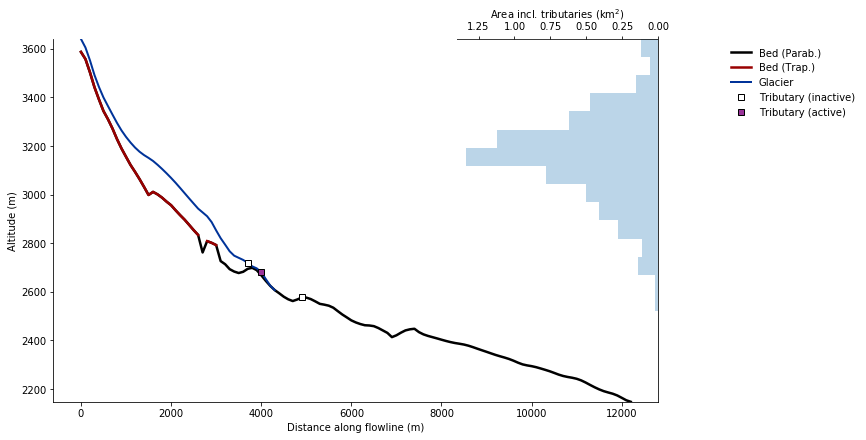

In [39]:
# Run for 50 years
commit_model.run_until(50)
graphics.plot_modeloutput_section(gdir_hef, model=commit_model)

Or until an equilibrium is reached (in this case it is possible because the mass-balance is constant in time):

2017-06-05 18:27:39: oggm.graphics: RGI50-11.00897: plot_modeloutput_section


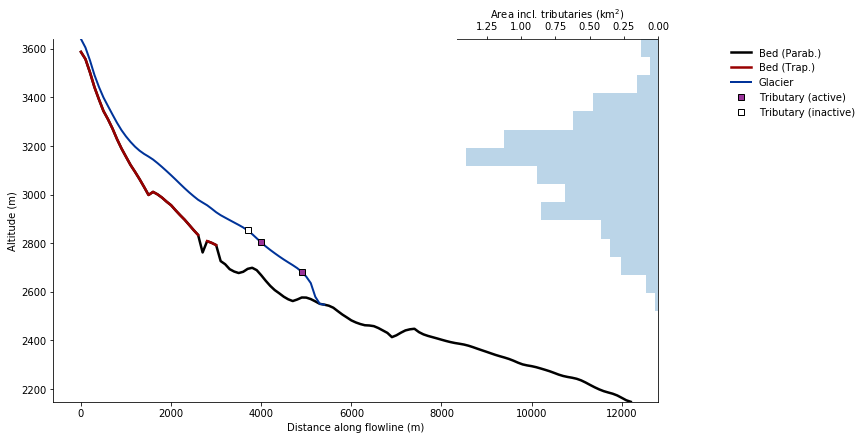

In [40]:
commit_model.run_until_equilibrium()
graphics.plot_modeloutput_section(gdir_hef, model=commit_model)

2017-06-05 18:27:40: oggm.graphics: RGI50-11.00897: plot_modeloutput_map


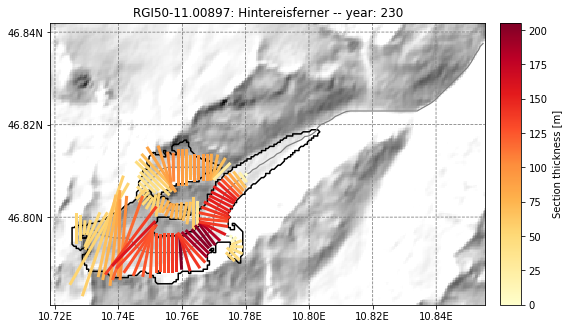

In [41]:
graphics.plot_modeloutput_map(gdir_hef, model=commit_model)

This is a very good example of how surprising glaciers can be. Let's redo this run and store the glacier evolution with time:

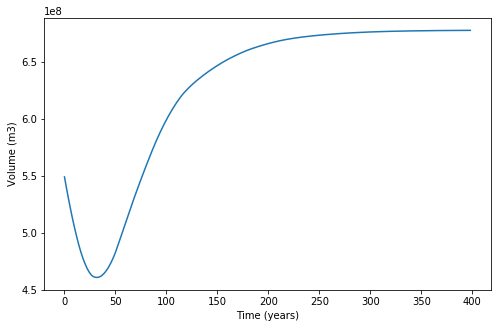

In [42]:
# Reinitialize the model (important!)
fls = gdir_hef.read_pickle('model_flowlines')
commit_model = FluxBasedModel(fls, mb_model=today_model, glen_a=cfg.A)
# Run and store
years = np.arange(200) * 2
volume = np.array([])
for y in years:
    commit_model.run_until(y)
    volume = np.append(volume, commit_model.volume_m3)
# Plot
plt.figure(figsize=(8, 5))
plt.plot(years, volume)
plt.ylabel('Volume (m3)');
plt.xlabel('Time (years)');

How important is the A parameter for the equilibrium volume?

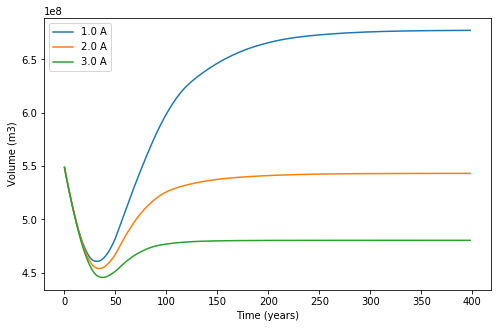

In [43]:
# Reinitialize the model (important!)
fls = gdir_hef.read_pickle('model_flowlines')
commit_model_1 = FluxBasedModel(fls, mb_model=today_model, glen_a=cfg.A*1)
fls = gdir_hef.read_pickle('model_flowlines')
commit_model_2 = FluxBasedModel(fls, mb_model=today_model, glen_a=cfg.A*2)
fls = gdir_hef.read_pickle('model_flowlines')
commit_model_3 = FluxBasedModel(fls, mb_model=today_model, glen_a=cfg.A*3)
# Run and store
years = np.arange(200) * 2
volume_1 = np.array([])
volume_2 = np.array([])
volume_3 = np.array([])
for y in years:
    commit_model_1.run_until(y)
    volume_1 = np.append(volume_1, commit_model_1.volume_m3)
    commit_model_2.run_until(y)
    volume_2 = np.append(volume_2, commit_model_2.volume_m3)
    commit_model_3.run_until(y)
    volume_3 = np.append(volume_3, commit_model_3.volume_m3)
# Plot
plt.figure(figsize=(8, 5))
plt.plot(years, volume_1, label='1.0 A')
plt.plot(years, volume_2, label='2.0 A')
plt.plot(years, volume_3, label='3.0 A')
plt.ylabel('Volume (m3)');
plt.xlabel('Time (years)');
plt.legend(loc='best');

### Random runs 

Equilibrium runs of course are not realistic. The normal variability of climate can lead to retreats and advances without any external forcing. OGGM therfore implements a random mass-balance model, which simply shuffles the *observed* years during a selected period of time.

In [44]:
from oggm.core.models.massbalance import RandomMassBalanceModel

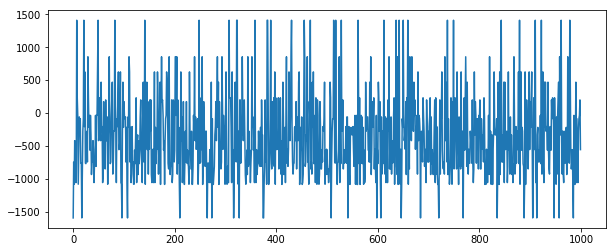

In [45]:
# Define the mass balance model
random_today = RandomMassBalanceModel(gdir, y0=1985, seed=0)

# Plot th specifi mass-balance
h, w = gdir.get_inversion_flowline_hw()
years = np.arange(1000)
mb_ts = random_today.get_specific_mb(h, w, year=years)
plt.figure(figsize=(10, 4))
plt.plot(years, mb_ts);

As you can see, the mass-balance has no visible trend. The time-series are not stricly gaussians, since only "observed" years can happen: the randomness occurs in the sequence of the events.

Let's make a run with this mass-balance:

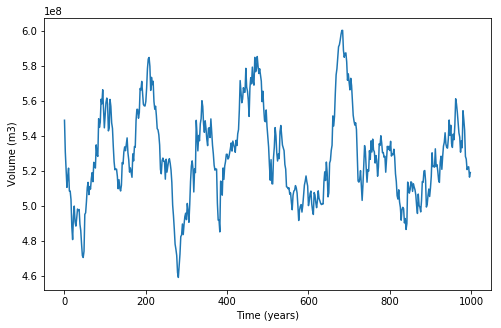

In [46]:
fls = gdir_hef.read_pickle('model_flowlines')
random_model = FluxBasedModel(fls, mb_model=random_today, glen_a=cfg.A*3)
# Run and store
years = np.arange(500) * 2
volume = np.array([])
for y in years:
    random_model.run_until(y)
    volume = np.append(volume, random_model.volume_m3)
# Plot
plt.figure(figsize=(8, 5))
plt.plot(years, volume)
plt.ylabel('Volume (m3)');
plt.xlabel('Time (years)');

Let's see what influence does the Glen's parameter A have on the glacier evolution. Note that if we use the same mass-balance model for all runs they will all have the same random climate sequence! This is very useful for various reasons.

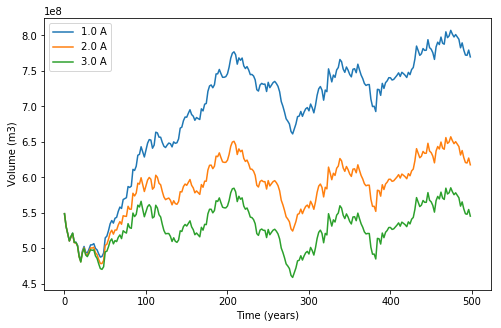

In [47]:
# Reinitialize the model (important!)
fls = gdir_hef.read_pickle('model_flowlines')
random_model_1 = FluxBasedModel(fls, mb_model=random_today, glen_a=cfg.A*1)
fls = gdir_hef.read_pickle('model_flowlines')
random_model_2 = FluxBasedModel(fls, mb_model=random_today, glen_a=cfg.A*2)
fls = gdir_hef.read_pickle('model_flowlines')
random_model_3 = FluxBasedModel(fls, mb_model=random_today, glen_a=cfg.A*3)
# Run and store
years = np.arange(250) * 2
volume_1 = np.array([])
volume_2 = np.array([])
volume_3 = np.array([])
for y in years:
    random_model_1.run_until(y)
    volume_1 = np.append(volume_1, random_model_1.volume_m3)
    random_model_2.run_until(y)
    volume_2 = np.append(volume_2, random_model_2.volume_m3)
    random_model_3.run_until(y)
    volume_3 = np.append(volume_3, random_model_3.volume_m3)
# Plot
plt.figure(figsize=(8, 5))
plt.plot(years, volume_1, label='1.0 A')
plt.plot(years, volume_2, label='2.0 A')
plt.plot(years, volume_3, label='3.0 A')
plt.ylabel('Volume (m3)');
plt.xlabel('Time (years)');
plt.legend(loc='best');

After the spin-up time, the three models have quite similar evolutions but quite different volumes!

Let's use different random series this time, keeping A constant:

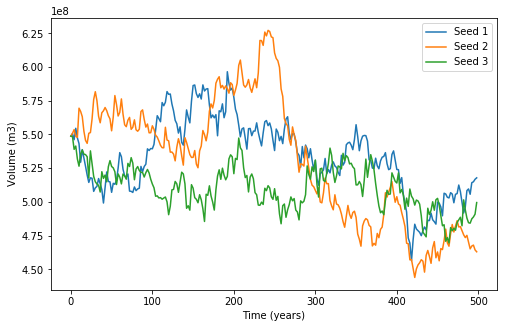

In [48]:
# Reinitialize the model (important!)
fls = gdir_hef.read_pickle('model_flowlines')
random_today = RandomMassBalanceModel(gdir, y0=1985, seed=1)
random_model_1 = FluxBasedModel(fls, mb_model=random_today, glen_a=cfg.A*3)
fls = gdir_hef.read_pickle('model_flowlines')
random_today = RandomMassBalanceModel(gdir, y0=1985, seed=2)
random_model_2 = FluxBasedModel(fls, mb_model=random_today, glen_a=cfg.A*3)
fls = gdir_hef.read_pickle('model_flowlines')
random_today = RandomMassBalanceModel(gdir, y0=1985, seed=3)
random_model_3 = FluxBasedModel(fls, mb_model=random_today, glen_a=cfg.A*3)
# Run and store
years = np.arange(250) * 2
volume_1 = np.array([])
volume_2 = np.array([])
volume_3 = np.array([])
for y in years:
    random_model_1.run_until(y)
    volume_1 = np.append(volume_1, random_model_1.volume_m3)
    random_model_2.run_until(y)
    volume_2 = np.append(volume_2, random_model_2.volume_m3)
    random_model_3.run_until(y)
    volume_3 = np.append(volume_3, random_model_3.volume_m3)
# Plot
plt.figure(figsize=(8, 5))
plt.plot(years, volume_1, label='Seed 1')
plt.plot(years, volume_2, label='Seed 2')
plt.plot(years, volume_3, label='Seed 3')
plt.ylabel('Volume (m3)');
plt.xlabel('Time (years)');
plt.legend(loc='best');

### Historical runs 

Now this is where it becomes interesting. Let's define a run with "real" mass-balance time-series. Let's assume that the 1850 glacier geometry is the same as today's, and run the model over 153 years:

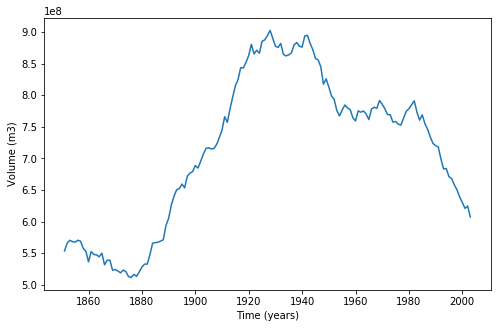

In [49]:
# Reinitialize the model (important!)
fls = gdir_hef.read_pickle('model_flowlines')
# Same as before with another mass-balance model and a real starting year y0:
model = FluxBasedModel(fls, mb_model=hist_model, glen_a=cfg.A*3, y0=1850)  
# Run and store
years = np.arange(153) + 1851
volume = np.array([])
for y in years:
    model.run_until(y)
    volume = np.append(volume, model.volume_m3)
# Plot
plt.figure(figsize=(8, 5))
plt.plot(years, volume)
plt.ylabel('Volume (m3)');
plt.xlabel('Time (years)');

Today's HEF would probably be too small to be in equilibrium with the climate during most of the simulation period. The time it needs to re-adjust depends on the glacier characteristics as well as A. We need a way to make our glacier grow first, so that it can shrink as we expect it to do.

2017-06-05 18:34:41: oggm.graphics: RGI50-11.00897: plot_modeloutput_map


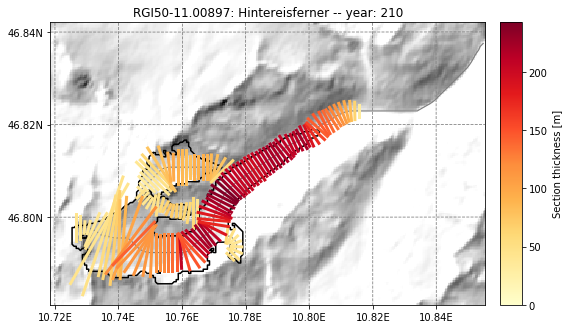

In [50]:
# Reinitialize the model (important!)
fls = gdir_hef.read_pickle('model_flowlines')
# Grow model: tstar climate
mb_model = ConstantMassBalanceModel(gdir_hef)
mb_model.temp_bias = -0.2
grow_model = FluxBasedModel(fls, y0=0, mb_model=mb_model, glen_a=cfg.A*3)
# run until equilibrium
grow_model.run_until_equilibrium()
# plot
graphics.plot_modeloutput_map(gdir_hef, model=grow_model)

Ok. Now reinitialize the historical run with this new input and see:

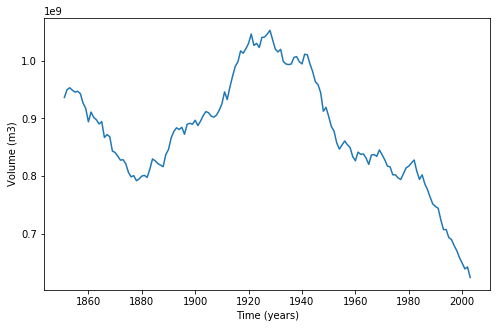

In [51]:
# Reinitialize the model with the new geom
fls = grow_model.fls
model = FluxBasedModel(fls, mb_model=hist_model, glen_a=cfg.A*3, y0=1850)  
# Run and store
years = np.arange(153) + 1851
volume = np.array([])
for y in years:
    model.run_until(y)
    volume = np.append(volume, model.volume_m3)
# Plot
plt.figure(figsize=(8, 5))
plt.plot(years, volume)
plt.ylabel('Volume (m3)');
plt.xlabel('Time (years)');

Looks better! But still not perfect:

2017-06-05 18:35:04: oggm.graphics: RGI50-11.00897: plot_modeloutput_map


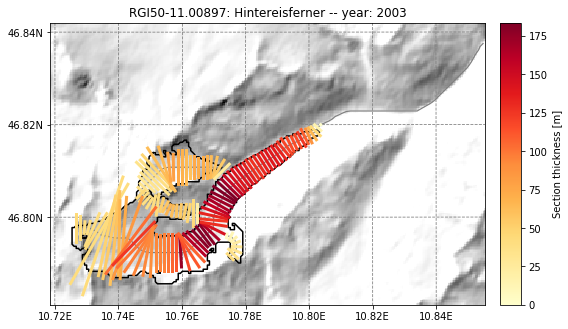

In [52]:
graphics.plot_modeloutput_map(gdir_hef, model=model)

There's still a lot to do!

### Regional runs 

In [53]:
workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs)

In [54]:
# for gdir in gdirs:
#     # the flowlines alone
#     fls = gdir.read_pickle('model_flowlines')
#     model = FluxBasedModel(fls)
#     graphics.plot_modeloutput_section(gdir, model=model)

The model interface presented above is useful to run tests and experiments, but it is not applicable at the regional scale. For this purpose, OGGM will implement entity tasks for the glacier evolution. Currently, only one is available:

In [55]:
workflow.execute_entity_task(tasks.random_glacier_evolution, gdirs, 
                             nyears=300, seed=0, filesuffix='_started')

RuntimeError: RGI50-11.00663: exception occured while processing task random_glacier_evolution